# Notebook to develop HMM model to investigate optimal angle selection

## Defining the targets we will be using in our multiaspect classification model

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.gridspec as gridspec

from scipy.special import spherical_jn, spherical_yn

import ipywidgets as widgets
from IPython.display import display

## Below is the analytical DWBA solution for a prolate spheroid geometry

In [2]:
def dwba_prolate_spheroid(L, a, g, h, ka, phi):
    """
    DWBA solution for a fluid prolate spheroid.
    Lee, W.-J., Lavery, A. C., and Stanton, T. K. (2012). 
    “Orientation dependence of broadband acoustic backscattering from live squid,” 
    The Journal of the Acoustical Society of America, 131, 4461–4475. doi:10.1121/1.3701876
    
    Parameters
    ----------
    L : float
        Length of spheroid (long axis) [m]
    a : float
        Radius of spheroid (short axis) [m]
    g : float
        Density contrast (rho2/rho1)
    h : float
        Sound speed contrast (c2/c1)
    ka : array_like
        Dimensionless ka (wavenumber * radius)
    phi : float or array_like
        Incident angle [radians]

    Returns
    -------
    fbs : array_like
        Complex backscattering amplitude
    """
    # Convert inputs to arrays and ensure proper broadcasting
    ka = np.atleast_1d(ka)
    phi = np.atleast_1d(phi)

    # Calculate contrast term
    contrast = 1/(g * h**2) + 1/g - 2
    
    # Convert incident angle to beta
    beta = phi[..., np.newaxis] + np.pi / 2  # Add dimension for broadcasting with ka
    # beta = phi + np.pi/2
    
    # Calculate aspect ratio term (L/2a)
    aspect_ratio = L / (2 * a)

    # Calculate argument for Bessel function
    ellip_term = np.sqrt(np.sin(beta)**2 + (aspect_ratio**2) * np.cos(beta)**2)
    bessel_arg = 2 * ka / h * ellip_term
    
    # Calculate spherical Bessel function
    j1 = spherical_jn(1, bessel_arg)
    
    # Calculate final backscattering amplitude
    fbs = (ka**2) * L * contrast/2 * j1/bessel_arg

    return fbs.squeeze()

## Defining the measurement and target constants

In [3]:
a = 0.15 # semi-minor axis (equatorial radius)
g = 1.043 # density contrast
h = 1.053 # sound speed contrast
c = 1500 # speed of sound in water

freq_lowerbound = 100 # frequency response lower bound
freq_upperbound = 30e3 # frequency response upper bound
freq = np.arange(freq_lowerbound, freq_upperbound, 10)
k = 2*np.pi*freq / c # acoustic wavenumber (phase shift per meter)
ka = k*a

measurement_angle_step = 0.5
angle_all = np.arange(0, 360, measurement_angle_step)

## Below is code borrowed from the [BOAT fundamentals repository](https://boat-fundamentals.readthedocs.io/en/latest/acoustics/TS_03_discrete.html#orientation-dependency)

It has been modified to include an aspect ratio parameter so we can see the 2 targets we need using the slider: a sphere (AR = 1) and spheroid (AR > 1)

In [4]:
def plot_dwba_for_prolate_spheroid(angle, aspect_ratio):
    L = aspect_ratio*2*a

    # TS across all angles
    phi_all = np.deg2rad(angle_all)
    fbs_full = dwba_prolate_spheroid(L, a, g, h, ka, phi_all)
    TS_all = 20*np.log10(np.abs(fbs_full))

    phi = np.deg2rad(angle)
    fbs = dwba_prolate_spheroid(L, a, g, h, ka, phi)
    TS = 20*np.log10(np.abs(fbs))

    # Define ellipse parameters
    width = 2*a  # width
    height = L  # height
    ellipse_angle = 90-angle  # rotation angle [deg]

    # Create the ellipse patch
    ellipse = patches.Ellipse(
        (0.5, 0.5), width, height, angle=ellipse_angle, 
        facecolor='lightblue', edgecolor='blue')

    fig = plt.figure(figsize=(7,6))
    gs = gridspec.GridSpec(2, 2, width_ratios=[2, 1])
    fig.subplots_adjust(hspace=0.1)

    # All angles
    ax0 = fig.add_subplot(gs[0,0])
    ax0.imshow(TS_all, aspect="auto", vmax=-25, vmin=-80,
                extent=(0, freq_upperbound//1e3, 0, 360))
    ax0.set_yticks(np.arange(0, 361, 60))
    ax0.set_ylabel("Incident angle (°)", fontsize=12)
    ax0.set_xlim(freq_lowerbound, freq_upperbound)
    ax0.axhline(angle, color="magenta")

    # One angle slice
    ax1 = fig.add_subplot(gs[1,0], sharex=ax0)
    ax1.plot(freq/1e3, TS, lw=0.75)
    ax1.set_xlim(freq_lowerbound/1e3, freq_upperbound/1e3)
    ax1.set_ylim(-90, -20)
    ax1.set_xlabel("Frequency (kHz)", fontsize=12)
    ax1.set_ylabel("TS (dB)", fontsize=12)

    # Ellipse (cross section of prolate spheroid)
    ax_ellip = fig.add_subplot(gs[1,1])
    ax_ellip.add_patch(ellipse)
    ax_ellip.annotate("Incident sound", xytext=(0.5, 1.2), xy=(0.5, 0.95),
        arrowprops=dict(arrowstyle="->,head_length=0.5,head_width=0.3",
                        linewidth=2),
        fontsize=12,
        ha="center")
    ax_ellip.set_aspect('equal', adjustable='box')
    ax_ellip.axis('off')
    ax_ellip.set_xlim(0, 1)
    ax_ellip.set_ylim(0, 1.2)

    ax0.set_title("TS of a fluid prolate spheroid")
    plt.tight_layout()
    plt.show()

    return TS_all

## Below I have attached two visualizations but both are using the same function

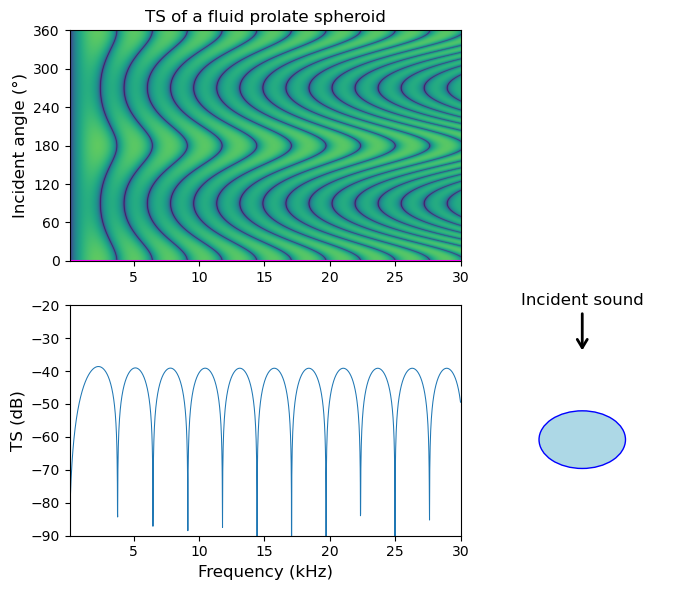

In [5]:
target1_AR = 1.5
TS_all_target1 = plot_dwba_for_prolate_spheroid(angle=0, aspect_ratio=target1_AR)

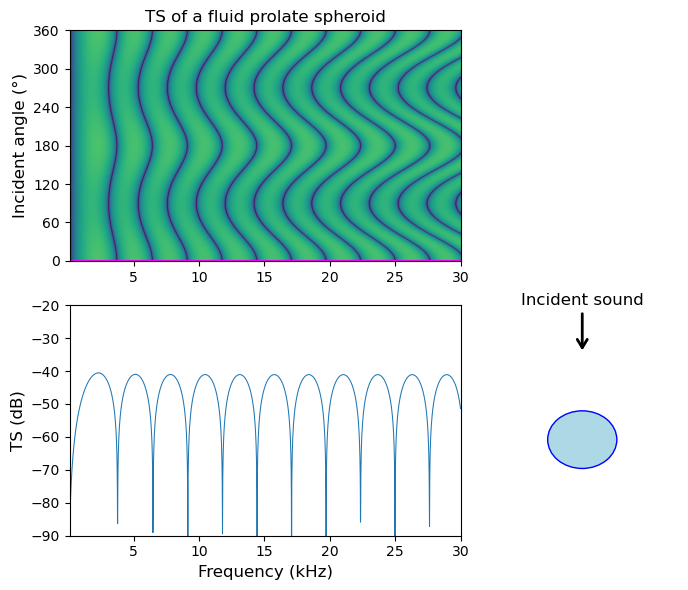

In [6]:
target2_AR = 1.2
TS_all_target2 = plot_dwba_for_prolate_spheroid(angle=0, aspect_ratio=target2_AR)

## Extract the acoustic color from the above functions and plot them side-by-side below

In [134]:
target_ARs = np.arange(1.5, 1.0, -0.3)
target_ARs

array([1.5, 1.2])

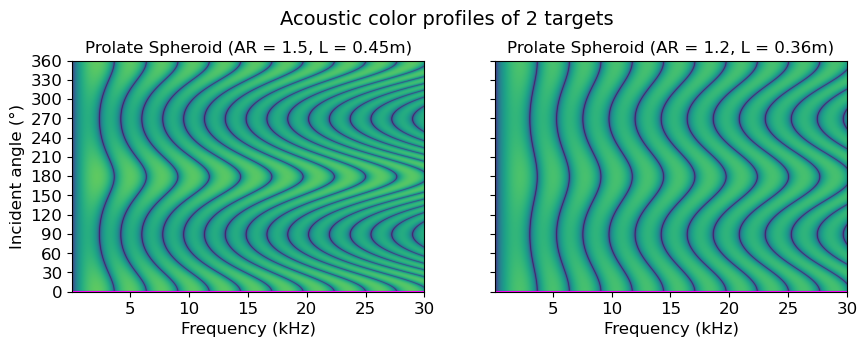

In [135]:
fig, ax = plt.subplots(1, target_ARs.shape[0], figsize=(5*target_ARs.shape[0],3), sharey=True)
plt.rcParams.update({'font.size':10})
fig.subplots_adjust(hspace=0.1)
fig.suptitle(f'Acoustic color profiles of {target_ARs.shape[0]} targets', y=1.05, fontsize=plt.rcParams['font.size']+4)

TS_all_targets = np.zeros((target_ARs.shape[0], angle_all.shape[0], freq.shape[0]))
for i, target_AR in enumerate(target_ARs):
    L = target_AR * 2*a
    phi_all = np.deg2rad(angle_all)
    fbs_full = dwba_prolate_spheroid(L, a, g, h, ka, phi_all)
    TS_all_targets[i,:,:] = 20*np.log10(np.abs(fbs_full))

    ax_TS = ax[i]
    ax_TS.set_title(f'Prolate Spheroid (AR = {target_AR:.1f}, L = {target_AR*2*a:.2f}m)')
    ax_TS.imshow(TS_all_targets[i,:] , aspect="auto", vmax=-25, vmin=-80,
                extent=(0, freq_upperbound//1e3, 0, 360))
    ax_TS.set_yticks(np.arange(0, 361, 30))
    if i==0:
        ax_TS.set_ylabel("Incident angle (°)", fontsize=12)
    ax_TS.axhline(0, color="magenta")
    ax_TS.set_xlim(freq_lowerbound/1e3, freq_upperbound/1e3)
    ax_TS.set_xlabel("Frequency (kHz)", fontsize=12)

plt.show()

In [136]:
all_waveforms_collection = np.vstack(TS_all_targets)
all_waveforms_collection

array([[-85.64708092, -83.99397243, -82.48527668, ..., -48.83383597,
        -49.13767041, -49.45380027],
       [-85.6470821 , -83.99397386, -82.48527838, ..., -48.87728219,
        -49.18283231, -49.5008053 ],
       [-85.64708564, -83.99397813, -82.48528347, ..., -49.0090163 ,
        -49.31981751, -49.64343629],
       ...,
       [-87.58528492, -85.93217721, -84.42348232, ..., -50.9104497 ,
        -51.21977789, -51.54181221],
       [-87.58528284, -85.9321747 , -84.42347933, ..., -50.8332707 ,
        -51.13952558, -51.45825588],
       [-87.5852816 , -85.93217319, -84.42347754, ..., -50.78730283,
        -51.09173925, -51.4085157 ]], shape=(1440, 2990))

In [137]:
from sklearn.cluster import KMeans
import seaborn as sns
import pandas as pd

/Users/adityakrishna/.local/share/mamba/envs/muri-info/lib/python3.13/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


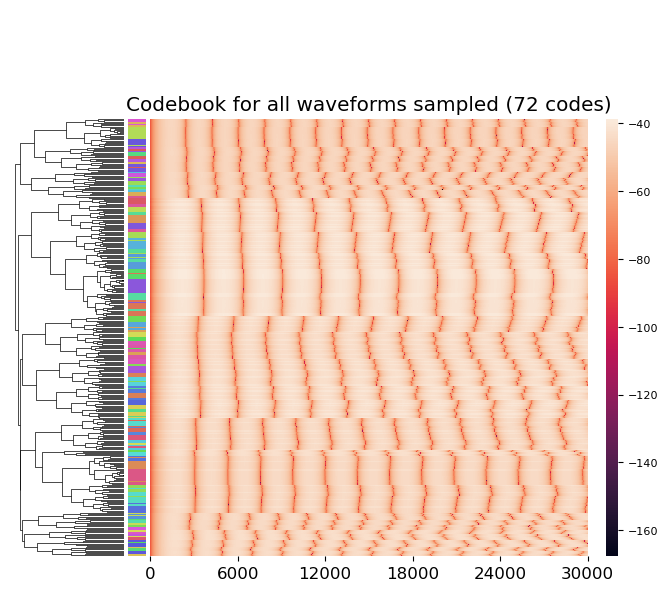

In [138]:
# Perform k-means clustering
k = all_waveforms_collection.shape[0]//20
state = 1500
kmean_TS_codebook = KMeans(n_clusters=k, n_init=10, random_state=state).fit(all_waveforms_collection)

# Create row colors for clustermap
labels = kmean_TS_codebook.labels_

# Get k distinct colors from a Seaborn palette
palette = sns.color_palette("hls", k)
# Map each cluster label to a color
row_colors = [palette[label] for label in labels]

plt.rcParams.update({'font.size':12})
# Create the clustermap
grid_cluster = sns.clustermap(
    all_waveforms_collection,
    col_cluster=False,
    row_colors=row_colors,
    cbar_pos=(1.0, 0.145, 0.02, 0.663),
    yticklabels=False,
    tree_kws=dict(linewidths=0.5, colors='k')
)

# Extract the figure and axes from sns.clustermap
fig = grid_cluster.figure
heatmap_ax = grid_cluster.ax_heatmap
dendro_ax = grid_cluster.ax_row_dendrogram

heatmap_ax.set_title(f'Codebook for all waveforms sampled ({k} codes)')
fig.set_figheight(6)
fig.set_figwidth(6)
# Adjust heatmap and dendrogram positions to align perfectly
heatmap_bbox = heatmap_ax.get_position(original=False)
dendro_bbox = dendro_ax.get_position(original=False)

# Reduce white space by directly setting the positions
heatmap_ax.set_position([heatmap_bbox.x0, heatmap_bbox.y0, heatmap_bbox.width, heatmap_bbox.height])
dendro_ax.set_position([dendro_bbox.x0, heatmap_bbox.y0, dendro_bbox.width, heatmap_bbox.height])

xticks = np.linspace(0, 3000, 6)
# Customize heatmap x-axis
heatmap_ax.set_xticks(xticks*(2985/3000))
heatmap_ax.set_xticklabels((xticks*10).astype(int), rotation=0)
heatmap_ax.set_ylabel('')
heatmap_ax.set_xlabel('')

# Adjust the colorbar position and labels
cbar = grid_cluster.cax
cbar.set_position([heatmap_bbox.x1 + 0.03, heatmap_bbox.y0, 0.02, heatmap_bbox.height]) 
cbar.tick_params(labelsize=plt.rcParams['font.size']-4)
plt.show()

In [139]:
state_angle_step = 5

In [140]:
kmean_TS_codebook.labels_

array([25, 25, 25, ..., 52, 52, 52], shape=(1440,), dtype=int32)

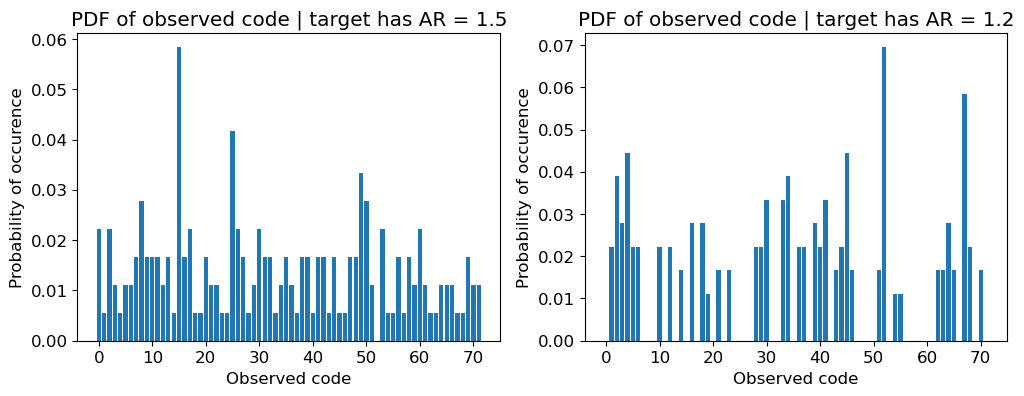

In [141]:
fig, ax = plt.subplots(1, TS_all_targets.shape[0], figsize=(6*TS_all_targets.shape[0], 4))

for i in range(TS_all_targets.shape[0]):
    target_cluster_preds = kmean_TS_codebook.predict(TS_all_targets[i,:])
    density, clusters = np.histogram(target_cluster_preds, bins=np.arange(0, kmean_TS_codebook.n_clusters+1), density=True)

    pdf_ax = ax[i]
    pdf_ax.set_title(f'PDF of observed code | target has AR = {target_ARs[i]:.1f}')
    pdf_ax.bar(x=clusters[:-1], height=density)
    pdf_ax.set_ylabel('Probability of occurence')
    pdf_ax.set_xlabel('Observed code')

plt.show()

In [142]:
state_centers = np.arange(0, 360, state_angle_step) + 2.5
state_centers

array([  2.5,   7.5,  12.5,  17.5,  22.5,  27.5,  32.5,  37.5,  42.5,
        47.5,  52.5,  57.5,  62.5,  67.5,  72.5,  77.5,  82.5,  87.5,
        92.5,  97.5, 102.5, 107.5, 112.5, 117.5, 122.5, 127.5, 132.5,
       137.5, 142.5, 147.5, 152.5, 157.5, 162.5, 167.5, 172.5, 177.5,
       182.5, 187.5, 192.5, 197.5, 202.5, 207.5, 212.5, 217.5, 222.5,
       227.5, 232.5, 237.5, 242.5, 247.5, 252.5, 257.5, 262.5, 267.5,
       272.5, 277.5, 282.5, 287.5, 292.5, 297.5, 302.5, 307.5, 312.5,
       317.5, 322.5, 327.5, 332.5, 337.5, 342.5, 347.5, 352.5, 357.5])

In [143]:
state_center = state_centers[0]
state_center

np.float64(2.5)

In [144]:
angle_indices_for_state = np.where((state_center-(state_angle_step/2)<=angle_all)&(angle_all<state_center+(state_angle_step/2)))
angle_indices_for_state

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),)

In [145]:
angle_all[angle_indices_for_state]

array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5])

In [146]:
TS_state_target1 = TS_all_targets[0, angle_indices_for_state, :][0]
TS_state_target1

array([[-85.64708092, -83.99397243, -82.48527668, ..., -48.83383597,
        -49.13767041, -49.45380027],
       [-85.6470821 , -83.99397386, -82.48527838, ..., -48.87728219,
        -49.18283231, -49.5008053 ],
       [-85.64708564, -83.99397813, -82.48528347, ..., -49.0090163 ,
        -49.31981751, -49.64343629],
       ...,
       [-85.64713858, -83.9940422 , -82.48535972, ..., -51.28524161,
        -51.69982702, -52.13650189],
       [-85.6471562 , -83.99406352, -82.48538509, ..., -52.20411446,
        -52.66873996, -53.16094575],
       [-85.64717615, -83.99408766, -82.48541383, ..., -53.38044615,
        -53.91743554, -54.49115328]], shape=(10, 2990))

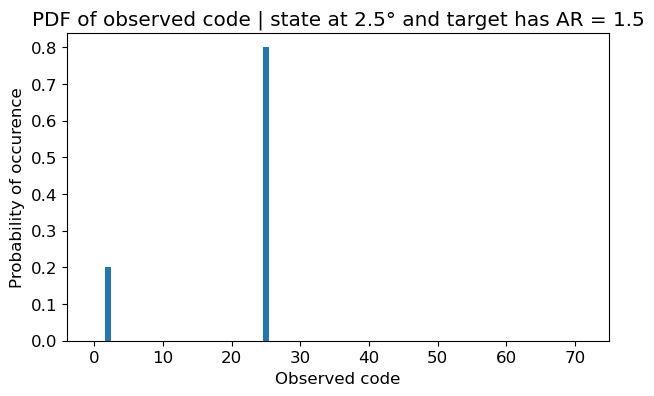

In [147]:
target1_state_cluster_preds = kmean_TS_codebook.predict(TS_state_target1)
density, clusters = np.histogram(target1_state_cluster_preds, bins=np.arange(0, kmean_TS_codebook.n_clusters+1), density=True)

fig, ax = plt.subplots(1, 1, figsize=(7,4))

ax.set_title(f'PDF of observed code | state at {state_center}° and target has AR = {target1_AR}')
ax.bar(x=clusters[:-1], height=density)
ax.set_ylabel('Probability of occurence')
ax.set_xlabel('Observed code')
plt.show()

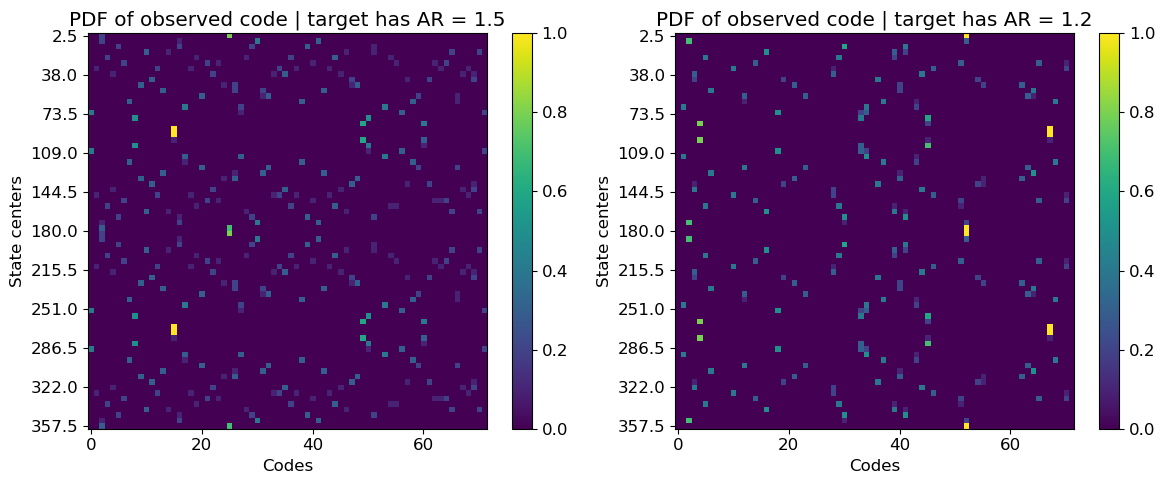

In [148]:
fig, ax_all = plt.subplots(1, TS_all_targets.shape[0], figsize=(6*TS_all_targets.shape[0], 5))

emission_matrix_B_targets = np.zeros((TS_all_targets.shape[0], state_centers.shape[0], kmean_TS_codebook.n_clusters))
for k in range(TS_all_targets.shape[0]):
    for i, state_center in enumerate(state_centers):
        angle_indices_for_state = np.where((state_center-(state_angle_step/2)<=angle_all)&(angle_all<state_center+(state_angle_step/2)))
        TS_state_target_k = TS_all_targets[k, angle_indices_for_state][0]
        target_k_state_cluster_preds = kmean_TS_codebook.predict(TS_state_target_k)

        density, clusters = np.histogram(target_k_state_cluster_preds, bins=np.arange(0, kmean_TS_codebook.n_clusters+1), density=True)
        emission_matrix_B_targets[k, i, :] = density

    ax = ax_all[k]
    im = ax.imshow(emission_matrix_B_targets[k], aspect='auto')
    fig.colorbar(im, ax=ax)
    ax.set_title(f'PDF of observed code | target has AR = {target_ARs[k]}')

    ax.set_yticks(np.linspace(0, state_centers.shape[0]-1, 11))
    ax.set_yticklabels(np.linspace(0, 355, 11)+2.5)
    ax.set_ylabel('State centers')
    ax.set_xlabel('Codes')

plt.tight_layout()
plt.show()

In [208]:
state_centers

array([  2.5,   7.5,  12.5,  17.5,  22.5,  27.5,  32.5,  37.5,  42.5,
        47.5,  52.5,  57.5,  62.5,  67.5,  72.5,  77.5,  82.5,  87.5,
        92.5,  97.5, 102.5, 107.5, 112.5, 117.5, 122.5, 127.5, 132.5,
       137.5, 142.5, 147.5, 152.5, 157.5, 162.5, 167.5, 172.5, 177.5,
       182.5, 187.5, 192.5, 197.5, 202.5, 207.5, 212.5, 217.5, 222.5,
       227.5, 232.5, 237.5, 242.5, 247.5, 252.5, 257.5, 262.5, 267.5,
       272.5, 277.5, 282.5, 287.5, 292.5, 297.5, 302.5, 307.5, 312.5,
       317.5, 322.5, 327.5, 332.5, 337.5, 342.5, 347.5, 352.5, 357.5])

In [209]:
def w_(theta):
    sigma_i = state_angle_step
    normalization = 1 / np.sqrt(2*np.pi*(sigma_i**2))

    return normalization * np.exp(-0.5*((theta/sigma_i)**2))

def state_transition_model(delta_angle):
    distances = np.abs(state_centers[:, np.newaxis] - state_centers[np.newaxis, :])

    return w_(distances - delta_angle)

In [210]:
initial_state_prob = state_angle_step / 360
initial_state = np.random.uniform(low=0, high=360)
initial_state

170.99762707394225

In [211]:
phi = np.deg2rad(initial_state)

true_target_L = target_ARs[1]*2*a
fbs = dwba_prolate_spheroid(true_target_L, a, g, h, ka, phi)

received_TS = 20*np.log10(np.abs(fbs))
received_TS

array([-87.58541451, -85.93233402, -84.42366896, ..., -58.1416538 ,
       -58.89997584, -59.73226536], shape=(2990,))

In [212]:
received_code = kmean_TS_codebook.predict(received_TS.reshape((1, freq.shape[0])))[0]
received_code

np.int32(2)

In [213]:
emission_matrix_B_targets[:,:,received_code]

array([[0.2, 0.2, 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0.1, 0.3, 0.2, 0.2, 0. ,
        0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. , 0. , 0. , 0. , 0.1, 0.3],
       [0. , 0.7, 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0.7, 0. , 0. , 0.7, 0. ,
        0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. , 0. , 0. , 0. , 0.7, 0. ]])

In [214]:
alpha_targets = initial_state_prob * emission_matrix_B_targets[:,:,received_code]
alpha_targets

array([[0.00277778, 0.00277778, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.00138889,
        0.00416667, 0.00277778, 0.00277778, 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.00138889, 0.00416667],
       [0.     

In [215]:
likelihood_targets = alpha_targets.sum(axis=1)
likelihood_targets

array([0.02222222, 0.03888889])

In [216]:
prior_class_prob = 1/2
posterior = (likelihood_targets*prior_class_prob) / np.sum(likelihood_targets*prior_class_prob)
posterior

array([0.36363636, 0.63636364])

In [217]:
entropy_of_belief = -1 * np.sum(posterior * np.log10(posterior + 1e-12))
entropy_of_belief

np.float64(0.2846721173926613)

In [218]:
candidate_angle_steps = np.arange(-1, 2, 2)
candidate_angle_steps

array([-1,  1])

In [219]:
candidate_next_states = candidate_angle_steps + initial_state
candidate_next_states

array([169.99762707, 171.99762707])

In [220]:
candidate_angle_step = candidate_angle_steps[0]
candidate_next_state = candidate_next_states[0]
candidate_next_state, candidate_angle_step

(np.float64(169.99762707394225), np.int64(-1))

In [221]:
A_step = state_transition_model(candidate_angle_step)
A_step

array([[0.07820854, 0.03883721, 0.00709492, ..., 0.        , 0.        ,
        0.        ],
       [0.03883721, 0.07820854, 0.03883721, ..., 0.        , 0.        ,
        0.        ],
       [0.00709492, 0.03883721, 0.07820854, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.07820854, 0.03883721,
        0.00709492],
       [0.        , 0.        , 0.        , ..., 0.03883721, 0.07820854,
        0.03883721],
       [0.        , 0.        , 0.        , ..., 0.00709492, 0.03883721,
        0.07820854]], shape=(72, 72))

In [222]:
predictive_code_prob = np.zeros((target_ARs.shape[0], kmean_TS_codebook.n_clusters))
marginal_code_dist = np.zeros(kmean_TS_codebook.n_clusters)
for i in range(target_ARs.shape[0]):
    predictive_code_prob[i,:] = np.matmul(np.matmul(alpha_targets[i], A_step), emission_matrix_B_targets[i])
    marginal_code_dist += posterior[i] * predictive_code_prob[i,:]

marginal_code_dist.shape

(72,)

In [223]:
joint_code_dist = (posterior.reshape((1, target_ARs.shape[0])).T * predictive_code_prob)
joint_code_dist.shape

(2, 72)

In [224]:
forecasted_posterior = joint_code_dist

In [225]:
forecasted_entropy_per_code = (forecasted_posterior * np.log10(forecasted_posterior + 1e-12)).sum(axis=0)
forecasted_entropy_per_code.shape

(72,)

In [226]:
(forecasted_entropy_per_code * marginal_code_dist).sum()

np.float64(-1.84094522292933e-05)

In [227]:
expected_posterior_entropies = np.zeros(candidate_angle_steps.shape[0])
for step_num, candidate_angle_step in enumerate(candidate_angle_steps):
    A_step = state_transition_model(candidate_angle_step)
    
    predictive_code_prob = np.zeros((target_ARs.shape[0], kmean_TS_codebook.n_clusters))
    marginal_code_dist = np.zeros(kmean_TS_codebook.n_clusters)
    for i in range(target_ARs.shape[0]):
        predictive_code_prob[i,:] = np.matmul(np.matmul(alpha_targets[i], A_step), emission_matrix_B_targets[i])
        marginal_code_dist += posterior[i] * predictive_code_prob[i,:]

    joint_code_dist = (posterior.reshape((1, target_ARs.shape[0])).T * predictive_code_prob)
    forecasted_posterior = joint_code_dist / joint_code_dist.sum(axis=0)
    forecasted_entropy_per_code = (forecasted_posterior * np.log10(forecasted_posterior + 1e-12)).sum(axis=0)
    expected_posterior_entropy = (forecasted_entropy_per_code * marginal_code_dist).sum()
    expected_posterior_entropies[step_num] = expected_posterior_entropy

In [228]:
(expected_posterior_entropies)

array([-0.0007073 , -0.00094733])

In [229]:
candidate_angle_steps[(expected_posterior_entropies).argmin()]

np.int64(1)

In [232]:
A_step.shape

(72, 72)

In [ ]:
alpha_targets.shape

(2, 72)

In [273]:
max_iter = 999
alpha_targets = np.zeros((max_iter+1, target_ARs.shape[0], state_centers.shape[0]))
prior_class_prob = np.ones(target_ARs.shape[0]) * 1/2
initial_state_prob = state_angle_step / 360
initial_state = np.random.uniform(low=0, high=360)
alpha_targets[0] = initial_state_prob
current_state = initial_state
states_tracked = []

for iter in range(max_iter):
    states_tracked += [current_state]
    phi = np.deg2rad(current_state)

    true_target_L = target_ARs[1]*2*a
    fbs = dwba_prolate_spheroid(true_target_L, a, g, h, ka, phi)

    received_TS = 20*np.log10(np.abs(fbs))
    received_code = kmean_TS_codebook.predict(received_TS.reshape((1, freq.shape[0])))[0]
    if iter==0:
        alpha_targets[iter+1] = alpha_targets[iter] * emission_matrix_B_targets[:,:,received_code]
    else:
        alpha_targets[iter+1] = np.matmul(alpha_targets[iter], A_step) * emission_matrix_B_targets[:,:,received_code]
    likelihood_targets = alpha_targets[iter+1].sum(axis=1)

    posterior = (likelihood_targets*prior_class_prob) / np.sum(likelihood_targets*prior_class_prob)
    entropy_of_belief = -1 * np.sum(posterior * np.log10(posterior + 1e-16))

    candidate_angle_steps = np.arange(-1, 2, 2)
    expected_posterior_entropies = np.zeros(candidate_angle_steps.shape[0])
    for step_num, candidate_angle_step in enumerate(candidate_angle_steps):
        A_step = state_transition_model(candidate_angle_step)
        
        predictive_code_prob = np.zeros((target_ARs.shape[0], kmean_TS_codebook.n_clusters))
        marginal_code_dist = np.zeros(kmean_TS_codebook.n_clusters)
        for i in range(target_ARs.shape[0]):
            predictive_code_prob[i,:] = np.matmul(np.matmul(alpha_targets[iter+1, i], A_step), emission_matrix_B_targets[i,:,:])
            marginal_code_dist += posterior[i] * predictive_code_prob[i,:]

        joint_code_dist = (posterior.reshape((1, target_ARs.shape[0])).T * predictive_code_prob)
        forecasted_posterior = joint_code_dist / (joint_code_dist.sum(axis=0) + 1e-16)
        forecasted_entropy_per_code = (forecasted_posterior * np.log10(forecasted_posterior + 1e-16)).sum(axis=0)
        expected_posterior_entropy = (forecasted_entropy_per_code * marginal_code_dist).sum()
        expected_posterior_entropies[step_num] = expected_posterior_entropy
    
    prior_class_prob = posterior.copy()
    current_state = (current_state + candidate_angle_steps[(entropy_of_belief - expected_posterior_entropies).argmax()]) % 360

/var/folders/qj/4txkrxcn2ld7mby9_6n6npnr0000gn/T/ipykernel_73684/2458423443.py:25: RuntimeWarning: invalid value encountered in divide
  posterior = (likelihood_targets*prior_class_prob) / np.sum(likelihood_targets*prior_class_prob)


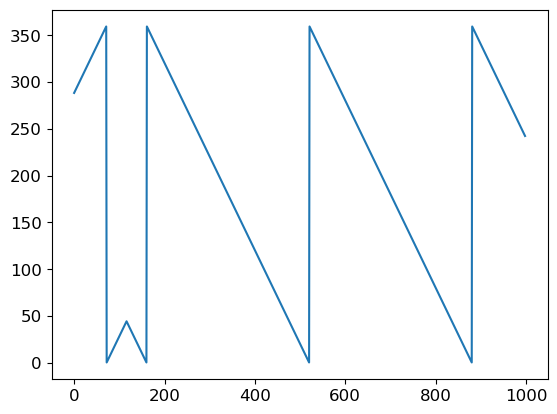

In [274]:
plt.plot(states_tracked)